# Disklab - RADMC-3D test

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import disklab
from disklab.natconst import *

plt.style.use(['seaborn', {'figure.dpi': 150}])

# 1D model
Set parameters & create a 1D disk model

In [ ]:
mstar      = 1*MS
lstar      = 1*LS
mdisk      = 0.03*mstar
flang      = 0.05
zrmax      = 1.0
nr         = 300
rin        = 1*au
rout       = 500*au
alpha      = 1e-3
kappa_dust = 1e2
d2g        = 0.01

dust_opac = ['dustcomponents',{'method':'simplemixing'}]
simple_opac = ['supersimple', {'dusttogas': 0.01, 'kappadust': kappa_dust}]
belllin_opac = ['belllin', {'onlygas': True}]

d=disklab.DiskModel(mstar=mstar,lstar=lstar,mdisk=mdisk,nr=nr,alpha=alpha,rin=rin,rout=rout)
d.make_disk_from_simplified_lbp(10, 60*AU, 1)
d.add_dust(agrain=1e-4, xigrain=1.2, dtg=0.005)
d.add_dust(agrain=1e-2, xigrain=1.2, dtg=0.005)

for dust in d.dust:
    # dust.grain.load_standard_opacity('ddn01','silicate') # this messes up the sizes
    dust.grain.read_opacity('../opacity/precalculated/dustkappa_silicate.inp',verbose=True)
    
d.meanopacitymodel = dust_opac
d.compute_mean_opacity()

In [ ]:
dust = d.dust[0]

In [ ]:
dust.grain.agrain

In [ ]:
dust.agrain[0]

In [ ]:
sig_d = np.sum([dust.sigma for dust in d.dust],0)

f, ax = plt.subplots()
ax.loglog(d.r / AU, d.sigma, label='gas')
ax.loglog(d.r / AU, sig_d, label='dust')
ax.legend()
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]');

## 2D model
Next we make a 2D disk model out of the 1D model. This should work with more complicated opacity as well. This works by using the mid-plane temperature of the 1D model and assuming it to be vertically isothermal. Furthermore, the dust is assumed to be well mixed with the gas.

In [ ]:
disk2d = disklab.DiskVert2D(disk=d, zrmax=zrmax, meanopacitymodel=d.meanopacitymodel, nz=50)

Plot the vertical structure

In [ ]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
plt.savefig('vertstruct1.pdf')

Update the dust density to settling-mixing equilibrium

In [ ]:
for vert in disk2d.verts:
    vert.compute_rhogas_hydrostatic()
    for dust in vert.dust:
        dust.compute_settling_mixing_equilibrium()

Plot the vertical structure again to compare

In [ ]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)
plt.savefig('vertstruct2.pdf')

# 2D radiative diffusion

Note: all the time is spent in the Fortran part, that is `disklab.diskvertstruct.diffusion.diffusion.solve_diffusion`

In [ ]:
vert = disk2d.verts[0]
dust = vert.dust[-1]
g = dust.grain

In [ ]:
id(d.dust[-1].grain)

In [ ]:
id(g)

In [ ]:
for vert in disk2d.verts:
    vert.compute_mean_opacity()
    vert.iterate_vertical_structure()

In [ ]:
disk2d.radial_raytrace()

In [ ]:
maxiter = 10
rhokap = []
for iter in range(maxiter):
    disk2d.radial_raytrace()
    disk2d.solve_2d_rad_diffusion(thist=True)
    for vert in disk2d.verts:
        vert.compute_rhogas_hydrostatic()

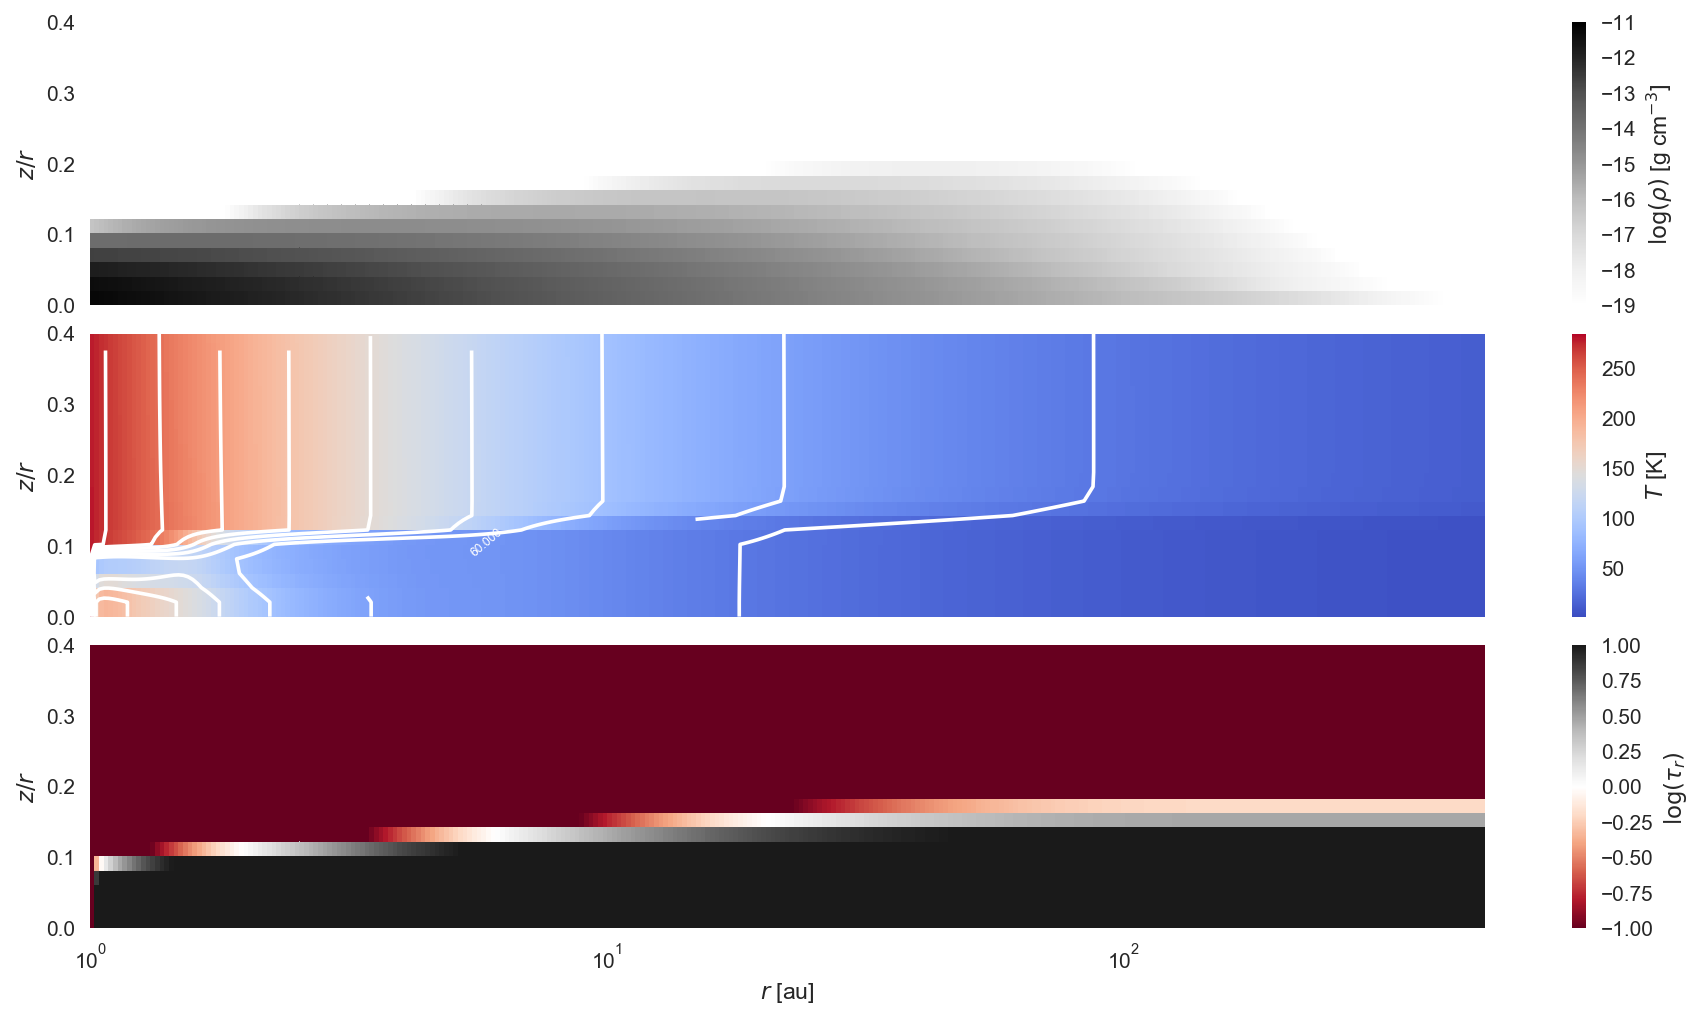

In [43]:
X0,Z0,rho0,T0,tau0,f = disklab.radmc3d.plot_vert_structure(disk2d)

## `RADMC3D` Setup

So far we were working in cylindrical coordinates, now we need to create spherical ones and interpolate onto those

In [ ]:
rmcd = disklab.radmc3d.get_radmc3d_arrays(disk2d, d2g, kappa_dust, showplots=False)

Assign the radmc3d data

In [ ]:
nphi   = rmcd['nphi']
ri     = rmcd['ri']
thetai = rmcd['thetai']
phii   = rmcd['phii']
nr     = rmcd['nr']
nth    = rmcd['nth']
nphi   = rmcd['nphi']
rho    = rmcd['rho']

Define a wavelength grid

In [ ]:
nlam = 200
lam = np.logspace(-5,0,nlam)
lam_mic = lam*1e4

Read default opacity and interpolate on wavelength grid:

In [ ]:
_lam,_kap_a,_kap_s = np.loadtxt('../../opacity/dustkappa_silicate.inp',skiprows=2).T
kappa_abs = 10.**np.interp(np.log10(lam_mic),np.log10(_lam),np.log10(_kap_a))
kappa_sca = 10.**np.interp(np.log10(lam_mic),np.log10(_lam),np.log10(_kap_s))

Write the `RADMC3D` input

In [ ]:
radmc3d_helper.write_stars_input(d,lam_mic)
radmc3d_helper.write_grid(ri, thetai, phii)
radmc3d_helper.write_dust_density(rho)
radmc3d_helper.write_wavelength_micron(lam_mic)
radmc3d_helper.write_opacity_grid(lam_mic, kappa_abs, kappa_sca=kappa_sca)
radmc3d_helper.write_opacity_info()
radmc3d_helper.write_radmc3d_input()

In [ ]:
radmc3d_helper.radmc3d('mctherm setthreads 4')

# RADMC3DPY

In [ ]:
from radmc3dPy import analyze, image
from scipy.interpolate import interp2d

Make and show an image

In [ ]:
rd = ri[np.where(rho[:,0]>1e-15)][-1]
image.makeImage(npix=500., wav=2.2, incl=40., phi=0., sizeau=2.3*rd/au,nostar=True,);
im = image.readImage()

In [ ]:
image.plotImage(im, au=True, log=True, maxlog=10, saturate=1e-1, cmap=plt.cm.gist_heat)

Read data structure

In [ ]:
grid = analyze.readGrid()
data = analyze.readData(dtemp=True,ddens=True,grid=grid,binary=False)
opac = analyze.readOpac(ext=['silicate'])

# Interpolate temperature on same grid


from scipy.interpolate import griddata
rho_sph = 10.**griddata(points,values,newpoints,fill_value=-100).reshape(len(r),len(theta))

newpoints = np.array(list(zip(X_c.flatten(),Y_c.flatten())))
T2 = griddata(points,T0.flatten(),newpoints)

Plot temperatures in comparison

In [ ]:
f,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4))

c2 = axs[0].pcolormesh(X0/au, Z0/X0, T0,cmap='coolwarm',vmin=0,vmax=400)
cb = plt.colorbar(c2,ax=axs[0])
cb.set_label(r'$T$')
axs[0].set_title('verts')

c1 = axs[1].pcolormesh(X_c/au, Y_c/X_c, data.dusttemp[:,:,0,0][:,::-1],cmap='coolwarm',vmin=0,vmax=400)
cb = plt.colorbar(c1,ax=axs[1])
cb.set_label(r'$T$')
axs[1].set_title('RADMC3D')


for ax in axs:
    ax.set_xlabel('r [AU]')
    ax.set_xscale('log')
    ax.set_ylim(0,0.4)
axs[0].set_ylabel(r'$\pi/2-\theta$');

In [ ]:
f,ax = plt.subplots()
ax.loglog(X_c[:,0]/au,data.dusttemp[:,-1,0,0],label='RADMC3D, mid-plane')
ax.loglog(X_c[:,0]/au,data.dusttemp[:,0,0,0],label='RADMC3D, $z=r$')
ax.loglog(X0[:,0]/au,T0[:,0],label='verts, mid-plane')
ax.loglog(X0[:,0]/au,T0[:,-1],label='verts, $z=r$')
ax.legend();

In [ ]:
f,axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(15,4))

c2 = axs[0].pcolormesh(X0/au, Z0/X0, np.log10(rho0),cmap='coolwarm',vmin=vmax-10,vmax=vmax)
cb = plt.colorbar(c2,ax=axs[0])
cb.set_label(r'$\log_{10}{\rho}$')
axs[0].set_title('verts')

c1 = axs[1].pcolormesh(X_c/au, Y_c/X_c, np.log10(data.rhodust[:,:,0,0][:,::-1]),cmap='coolwarm',vmin=vmax-10,vmax=vmax)
cb = plt.colorbar(c1,ax=axs[1])
cb.set_label(r'$\log_{10}{\rho}$')
axs[1].set_title('RADMC3D')


for ax in axs:
    ax.set_xlabel('r [AU]')
    ax.set_xscale('log')
    ax.set_ylim(0,0.4)
axs[0].set_ylabel(r'$\pi/2-\theta$')

f.subplots_adjust(hspace=0,wspace=0);